## Liste des articles déjà achetés
Dans ce notebook, nous dressons la liste des articles déjà achetés pour chaque client, et regardons le score obtenu.
Cela nous permet d'obtenir un score de base auquel comparer les résultats des modèles ultérieurs.

Par la suite elle sera utile pour générer une sélection restreinte d'articles par client, sur laquelle entraîner le modèle.

In [1]:
import pandas as pd
import numpy as np
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
# Import des transactions
transactions = pd.read_pickle('pickles/transactions_clean.pkl')

# Modifications propres à la présente manipulation
last_day = transactions['t_dat'].max()
transactions['day_number'] = (last_day - transactions['t_dat']).dt.days

transactions = transactions[['article_id', 'day_number', 'customer_id']].drop_duplicates()

In [3]:
# Création de la table voulue
already_purchased = transactions.groupby(['customer_id', 'article_id'], as_index = False, sort = False).agg(
    days_list = ('day_number', lambda x: list(x)) # Le tableau est censé déjà être trié .
)

In [4]:
# Ajout de champs supplémentaires après le groupage, celui-ci étant déjà lourd. 
already_purchased['count'] = already_purchased['days_list'].apply(lambda x: len(x))
already_purchased['last_day'] = already_purchased['days_list'].apply(lambda x: x[0])
already_purchased['first_day'] = already_purchased['days_list'].apply(lambda x: x[-1])

In [5]:
already_purchased.to_pickle("pickles/list_already_purchased.pkl")
already_purchased.head()

,customer_id,article_id,days_list,count,last_day,first_day
0,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,0898573003,[0],1,0,0
1,53d5f95331b01525404c3cbb2da6a84e1173dccb979d28...,0752814021,"[0, 1]",2,0,1
2,53da4b44e81286ed175a46d8ffd5a2baf47843089dc03f...,0793506006,[0],1,0,0
3,53da4b44e81286ed175a46d8ffd5a2baf47843089dc03f...,0802459001,[0],1,0,0
4,53da4b44e81286ed175a46d8ffd5a2baf47843089dc03f...,0874169001,[0],1,0,0


#### Affichage des intervalles entre deux rachats

In [9]:
intervals = []

def append_interval(day_list):
    end = len(day_list)
    
    for i in range(0, end):
        for j in range(i + 1, end):
            interval = day_list[j] - day_list[i]
            
            intervals.append(interval)

blank = already_purchased[already_purchased['count'] > 1]['days_list'].swifter.apply(append_interval)

Pandas Apply: 100%|██████████| 1141216/1141216 [00:01<00:00, 992716.68it/s] 


In [10]:
intervals_distribution = pd.Series(intervals).value_counts()
intervals_distribution.to_pickle('pickles/repurchases_interval_distribution.pkl')

In [8]:
intervals_distribution = pd.read_pickle('pickles/repurchases_interval_distribution.pkl')

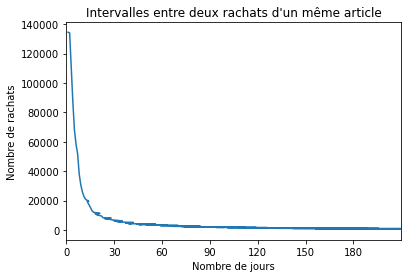

In [18]:
plt.figure()
plt.plot(intervals_distribution.index, intervals_distribution)
plt.xticks([0, 30, 60, 90, 120, 150, 180])
plt.xlim(0, 210)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de rachats")
plt.title("Intervalles entre deux rachats d'un même article")
plt.show()

In [25]:
interval_normalized = pd.Series(intervals).value_counts(normalize = True)
print("Pourcentage de rachats effectués dans les 15 jours : ", interval_normalized.iloc[0:15].sum())
print("Pourcentage de rachats après 30 jours : ", interval_normalized.iloc[31:].sum())

Pourcentage de rachats effectués dans les 15 jours :  0.5786424064449749
Pourcentage de rachats après 90 jours :  0.18938098654944338


Observations : 
- 57% des rachats d'un même article se font dans les 15 jours.

In [3]:
already_purchased = pd.read_pickle("pickles/list_already_purchased.pkl")

In [11]:
# Ajout des données client et produit
customers = pd.read_pickle('pickles/customers_second_iteration.pkl')
customers = customers[['customer_id', 'repurchases', 'repurchases_interval']]

articles = pd.read_pickle('pickles/articles_second_iteration.pkl')
articles = articles[['article_id', 'repurchases', 'repurchase_interval']]

already_purchased = already_purchased.merge(customers, on = 'customer_id', how = 'left')
already_purchased = already_purchased.merge(articles, on = 'article_id', how = 'left', suffixes = ('_customer', '_article'))

In [12]:
already_purchased['mean_interval'] = (already_purchased['repurchases_interval'] + already_purchased['repurchase_interval']) / 2
already_purchased['score'] = already_purchased['repurchases_article'] * already_purchased['repurchases_customer']

already_purchased['interval_weighted'] =  already_purchased['last_day'] / already_purchased['mean_interval']
already_purchased = already_purchased[already_purchased['interval_weighted'] <= 50]

In [13]:
already_purchased['score'] *= already_purchased['interval_weighted'].apply(lambda x: 
    intervals_distribution.loc[max(round(x), 1)]
)

In [14]:
already_purchased = already_purchased[['customer_id', 'article_id', 'score']].sort_values(['customer_id', 'score'], ascending = False)

In [15]:
already_purchased.reset_index(drop = True, inplace = True)

In [16]:
# Finalisation de la liste.

repurchase_lists = already_purchased.groupby('customer_id', as_index = False, sort = False).agg(
    list = ('article_id', lambda x: list(x))
)

repurchase_lists['list'] = repurchase_lists['list'].apply(lambda x: x[0:101])

repurchase_lists.to_pickle('pickles/already_purchased_list.pkl')

In [36]:
# Création du fichier de soumission Kaggle.
repurchase_lists['prediction'] = repurchase_lists['list'].apply(lambda x: ' '.join(x[0:12]))

In [37]:
customers = pd.read_pickle("pickles/customers_clean.pkl")
submission = customers[['customer_id']]
submission = customers[['customer_id']].merge(repurchase_lists[['customer_id', 'prediction']], on  = "customer_id", how = 'left').fillna("")
submission.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0795440001 0841260003 0859416011 08...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0826211002 0351484002 0559630026 0599580055 05...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0750424014 0851400006 0852643001 08...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0732413001 0742079001
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0927530004 0896152002 0791587015 0730683050 08...


In [38]:
submission.to_csv('submissions/submission_already_purchased.csv', index = False)

**Score MAP@12 de la soumission Kaggle : 0.01920**